<a href="https://colab.research.google.com/github/sanjanavenkatesan/analysis/blob/master/SCIOassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Importing necessary libraries**

In [0]:
#@title Default title text
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import to_graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix


**Loading data**

In [108]:
df=pd.read_csv('/content/drive/My Drive/SCIO/diabetic_data.csv',na_values=["NA"," ","?"])
df1=pd.read_csv('/content/drive/My Drive/SCIO/IDs_mapping.csv',na_values=["NA"," ","?"],header=None)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Mapping IDs**

In [0]:
# Separating the ID mapping info via row indexing
admission_type_id = df1[1:10]
discharge_disposition_id = df1[11:42]
admission_source_id = df1[43:68]

# Creating dictionaries for the ID mapping
admission_type_id_dict = dict(zip(admission_type_id[0], admission_type_id[1]))
discharge_disposition_id_dict = dict(zip(discharge_disposition_id[0], discharge_disposition_id[1]))
admission_source_id_dict = dict(zip(admission_source_id[0], admission_source_id[1]))

# Adding new columns to the main dataset that will contain mapped ID info
id_cols = ["admission_type_id", "discharge_disposition_id", "admission_source_id"]
df[id_cols] = df[id_cols].astype(str)
# Mapping IDs to each patient using the dictionaries created above
df["admission_type"]= df["admission_type_id"].map(admission_type_id_dict)
df["discharge_disposition"]= df["discharge_disposition_id"].map(discharge_disposition_id_dict)
df["admission_source"]= df["admission_source_id"].map(admission_source_id_dict)


Some patients have EXPIRED as per their discharge disposition.

In [110]:
#Dropping expired patients
print("The number of expired patients is {}".format(len(df[(df["discharge_disposition_id"] == "11") | (df["discharge_disposition_id"] == "19") | (df["discharge_disposition_id"] == "20")])))



The number of expired patients is 1652


In [0]:
df.drop_duplicates(keep=False,inplace=True)

**Analysing missing values**

In [112]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

weight                      96.858479
medical_specialty           49.082208
payer_code                  39.557416
admission_source             6.663326
admission_type               5.199182
discharge_disposition        3.626948
race                         2.233555
diag_3                       1.398306
diag_2                       0.351787
diag_1                       0.020636
patient_nbr                  0.000000
admission_type_id            0.000000
A1Cresult                    0.000000
max_glu_serum                0.000000
number_diagnoses             0.000000
number_inpatient             0.000000
number_emergency             0.000000
number_outpatient            0.000000
num_medications              0.000000
gender                       0.000000
num_lab_procedures           0.000000
metformin                    0.000000
age                          0.000000
time_in_hospital             0.000000
admission_source_id          0.000000
discharge_disposition_id     0.000000
num_procedur

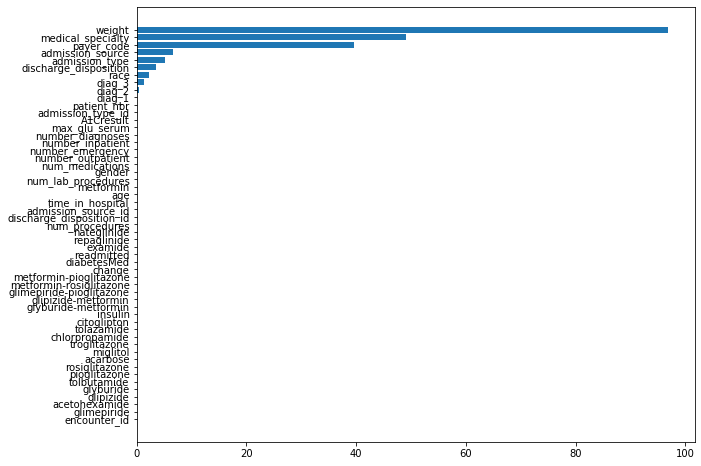

In [113]:
plt.figure(figsize=(10,8))
missing = pd.DataFrame({'column':df.columns ,'na_percent':df.isnull().sum()/len(df)*100})
missing.sort_values('na_percent',inplace=True)
missing_percent=(df.isnull().sum()/len(df)*100)

print(missing_percent.sort_values(ascending=False))
plt.barh(missing['column'],width=missing['na_percent']);


In [0]:
#Dropping the columns with high null value percentage
df.drop(['weight','medical_specialty','payer_code'],axis=1,inplace=True)

In [115]:
df.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


**Grouping**

Grouping the values according to 'International Statistical Classification of Diseases and Related Health Problems'(ICD codes)

In [0]:
def grouping(i):
  i=str(i)
  if(i[0].isnumeric()==True):
    i=pd.to_numeric(i)
    if(1>=i<=39):
      return "1-139"
    elif(140<=i<=239):
      return "140-239"
    elif(240<=i<=279):
      return "240-279"
    elif(280<=i<=289):
      return "280-289"
    elif(290<=i<=319):
      return "290-319"
    elif(320<=i<=389):
      return "320-389"
    elif (390 <= i <= 459):
        return "390-459"
    elif (460 <= i <= 519):
        return "460-519"
    elif (520 <= i <= 579):
        return "520-579"
    elif (580 <= i <= 629):
        return "580-629"
    elif (630 <= i <= 679):
        return "630-679"
    elif (680 <= i <= 709):
        return "680-709"
    elif (710 <= i <= 739):
        return "710-739"
    elif (740 <= i <= 759):
        return "740-759"
    elif (760 <= i <= 779):
        return "760-779"
    elif (780 <= i <= 799):
        return "780-799"
    else:
        return "800-999"
  elif (i == "unknown"):  
      return "unknown" 
  else:
      return "EV_code"

In [0]:

df["diag_1_grouped"] = df["diag_1"].apply(grouping)
df["diag_2_grouped"] = df["diag_2"].apply(grouping)
df["diag_3_grouped"] = df["diag_3"].apply(grouping)

# Dropping the original diagnosis columns
df.drop(["diag_1", "diag_2", "diag_3"], axis = 1, inplace = True)




**Data Visualization**

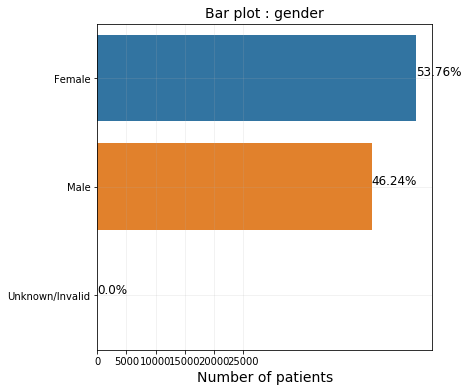

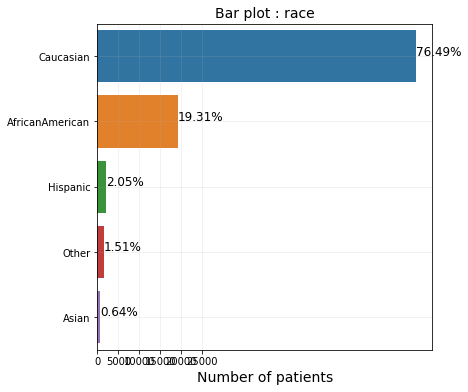

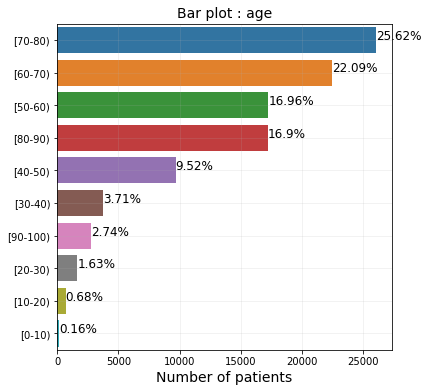

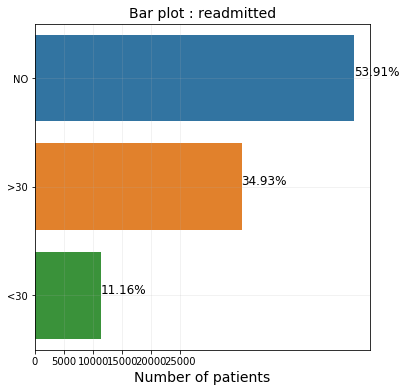

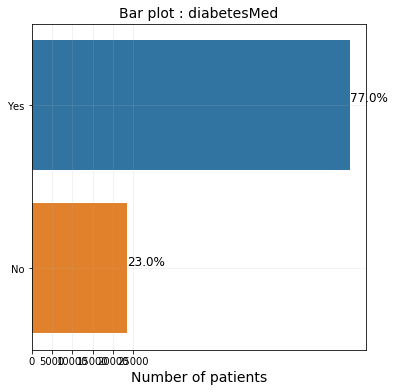

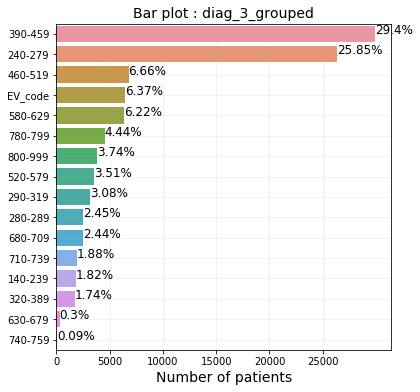

In [118]:
temp = ["gender", "race", "age", "readmitted", "diabetesMed", "diag_3_grouped"]
for col in df[temp]:
    plt.figure(figsize=(6,6))
    ax = sns.countplot(y = col, data = df, order = df[col].value_counts().index);
    ax.set_alpha(0.8)
    ax.set_title("Bar plot : {}".format(col), fontsize=14)
    ax.set_xlabel("Number of patients", fontsize=14)
    ax.set_ylabel("")
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.set_xticks(range(0, 30000, 5000))
    ax.grid(alpha = 0.2)
# Add percentages to individual bars
    totals = []
    for i in ax.patches:
        totals.append(i.get_width())
    total = sum(totals)
    for i in ax.patches:
        ax.text(i.get_width()+.3, i.get_y()+.38, \
                str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
    color='black')

    plt.show()
    print()

Text(0.5, 1.0, 'Distribution of Readmission')

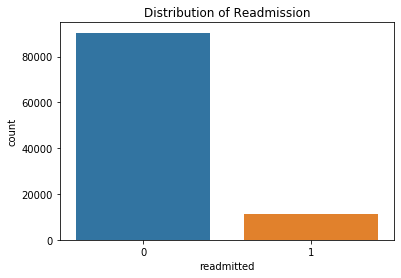

In [119]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

sns.countplot(df["readmitted"]).set_title('Distribution of Readmission')

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

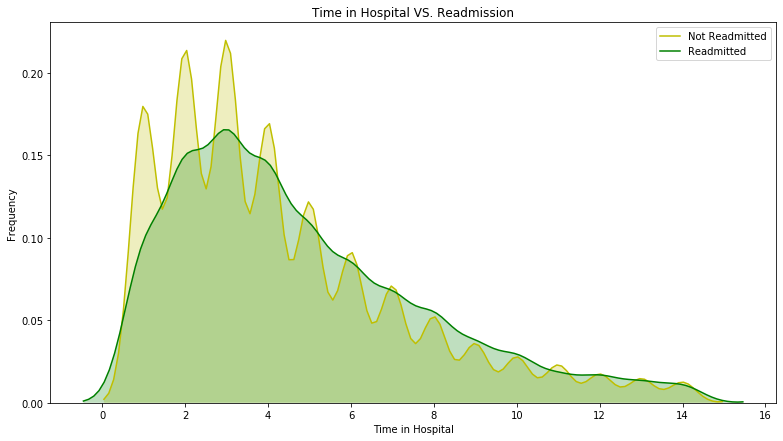

In [120]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='y',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='g',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

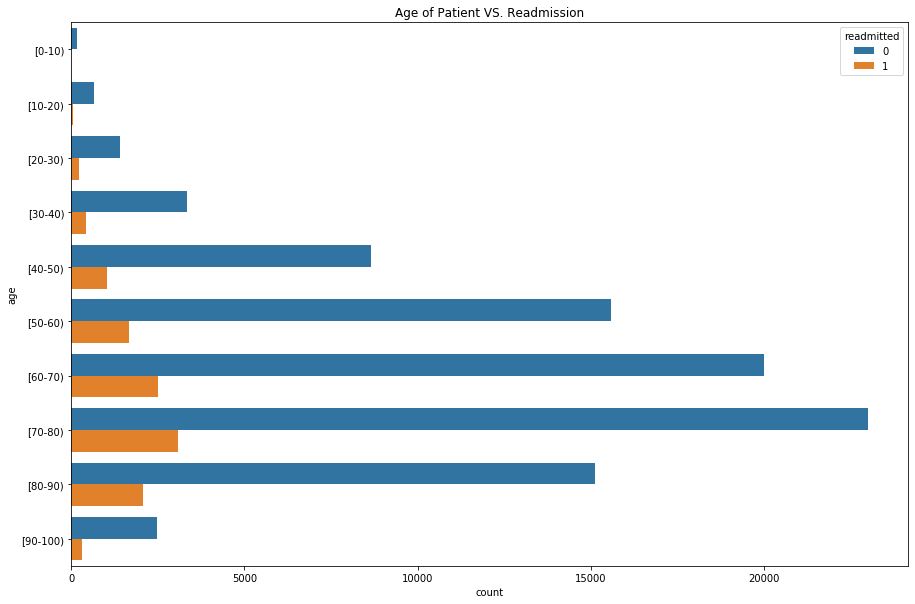

In [121]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')

Text(0.5, 1.0, 'Number of medication used VS. Readmission')

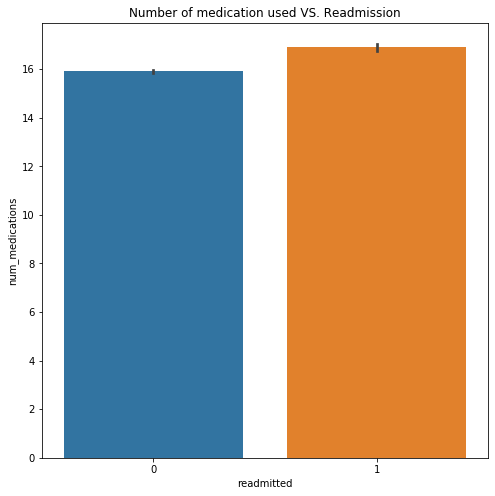

In [122]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used VS. Readmission")

Text(0.5, 1.0, 'Gender of Patient VS. Readmission')

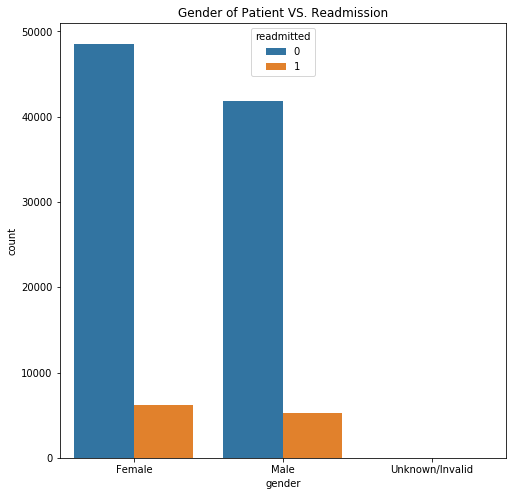

In [123]:
fig = plt.figure(figsize=(8,8))
sns.countplot(df['gender'], hue = df['readmitted']).set_title("Gender of Patient VS. Readmission")

Text(0.5, 1.0, 'Change of Medication VS. Readmission')

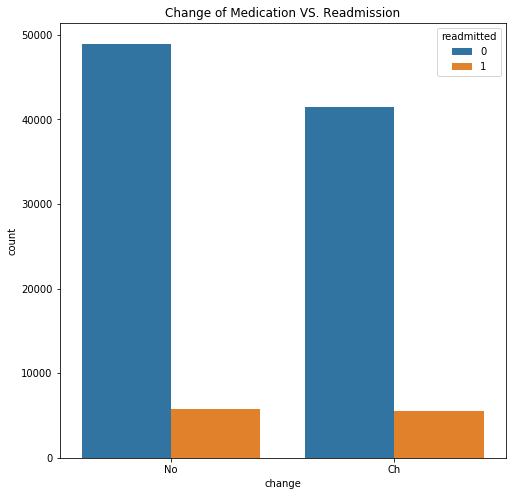

In [124]:
fig = plt.figure(figsize=(8,8))
sns.countplot(df['change'], hue = df['readmitted']).set_title('Change of Medication VS. Readmission')

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

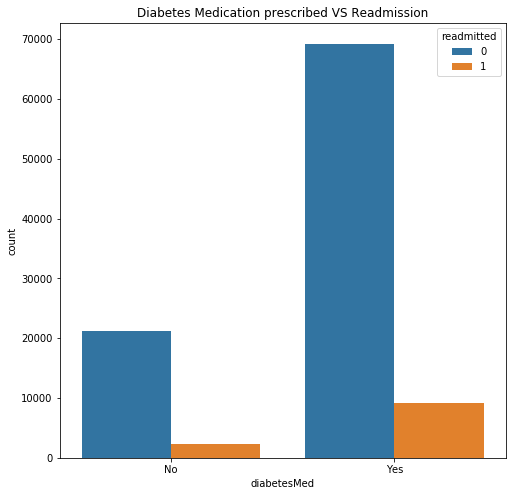

In [125]:
fig = plt.figure(figsize=(8,8))
sns.countplot(df['diabetesMed'], hue = df['readmitted']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Glucose test serum test result VS. Readmission')

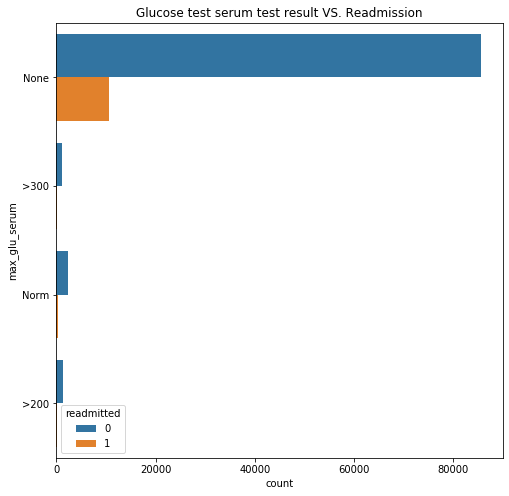

In [126]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['max_glu_serum'], hue = df['readmitted']).set_title('Glucose test serum test result VS. Readmission')

Text(0.5, 1.0, 'A1C test result VS. Readmission')

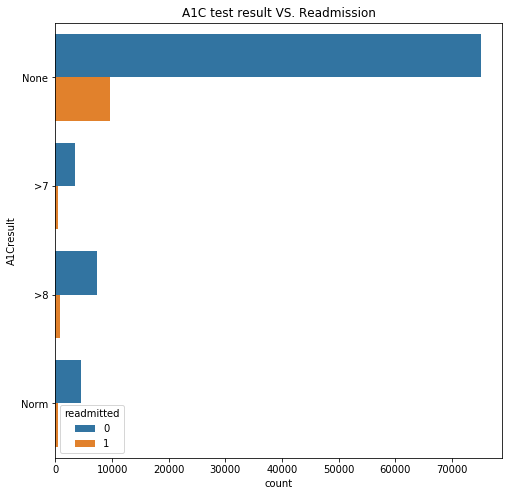

In [127]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y= df['A1Cresult'], hue = df['readmitted']).set_title('A1C test result VS. Readmission')

Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

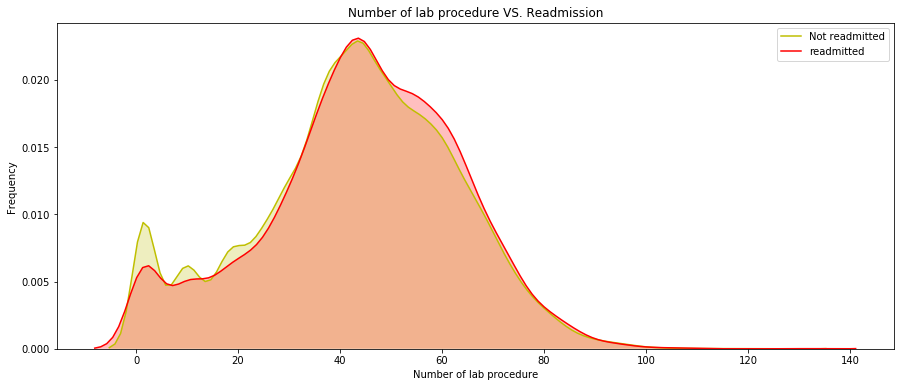

In [128]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='y',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

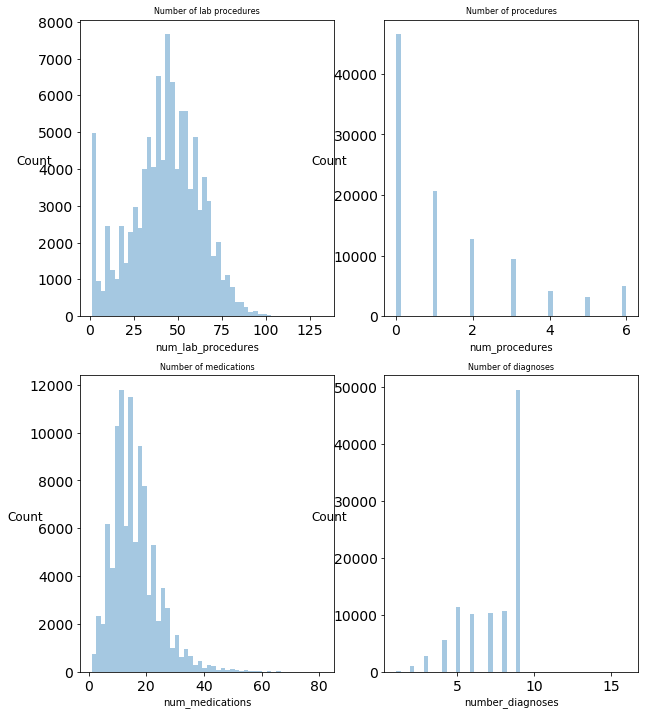

In [129]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 12))
a = sns.distplot(a = df["num_lab_procedures"], kde = False, ax=ax[0, 0])
a.axes.set_title("Number of lab procedures", fontsize=8)
a.tick_params(labelsize=14)
a.set_ylabel("Count", fontsize = 12, rotation = 0)
b = sns.distplot(a = df["num_procedures"], kde = False, ax=ax[0, 1])
b.axes.set_title("Number of procedures", fontsize=8)
b.tick_params(labelsize=14)
b.set_ylabel("Count", fontsize = 12, rotation = 0)
c = sns.distplot(a = df["num_medications"], kde = False, ax=ax[1, 0])
c.axes.set_title("Number of medications", fontsize=8)
c.tick_params(labelsize=14)
c.set_ylabel("Count", fontsize = 12, rotation = 0)
d = sns.distplot(a = df["number_diagnoses"], kde = False, ax=ax[1, 1])
d.axes.set_title("Number of diagnoses", fontsize=8)
d.tick_params(labelsize=14)
d.set_ylabel("Count", fontsize = 12, rotation = 0)
fig.show()

**Correlation plot**

In [130]:
corr = df.corr()
cm = sns.light_palette("yellow", as_cmap=True) 
corr.style.background_gradient(cmap = cm, axis = None).set_properties(**{"max-width": "50p", "font-size": "10pt"}).set_precision(1)

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
encounter_id,1,0.5,-0.06,-0.03,-0.01,0.08,0.1,0.08,0.03,0.3,-0.009
patient_nbr,0.5,1,-0.02,0.02,-0.02,0.02,0.1,0.06,0.01,0.2,0.008
time_in_hospital,-0.06,-0.02,1,0.3,0.2,0.5,-0.009,-0.01,0.07,0.2,0.04
num_lab_procedures,-0.03,0.02,0.3,1,0.06,0.3,-0.008,-0.002,0.04,0.2,0.02
num_procedures,-0.01,-0.02,0.2,0.06,1,0.4,-0.02,-0.04,-0.07,0.07,-0.01
num_medications,0.08,0.02,0.5,0.3,0.4,1,0.05,0.01,0.06,0.3,0.04
number_outpatient,0.1,0.1,-0.009,-0.008,-0.02,0.05,1,0.09,0.1,0.09,0.02
number_emergency,0.08,0.06,-0.01,-0.002,-0.04,0.01,0.09,1,0.3,0.06,0.06
number_inpatient,0.03,0.01,0.07,0.04,-0.07,0.06,0.1,0.3,1,0.1,0.2
number_diagnoses,0.3,0.2,0.2,0.2,0.07,0.3,0.09,0.06,0.1,1,0.05


**Outlier Analysis**

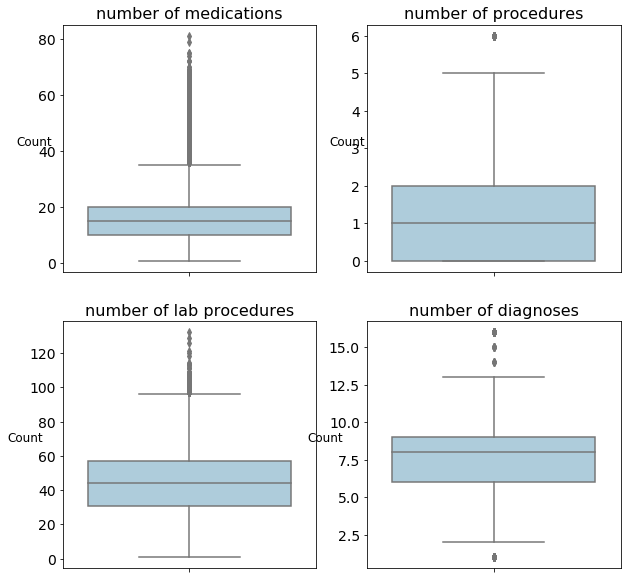

In [131]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))
a = sns.boxplot(y = df["num_medications"], ax=ax[0, 0], palette = "Paired")
a.axes.set_title("number of medications", fontsize=16)
a.tick_params(labelsize=14)
a.set_ylabel("Count", fontsize = 12, rotation = 0)
b = sns.boxplot(y = df["num_procedures"], ax=ax[0, 1], palette = "Paired")
b.axes.set_title("number of procedures", fontsize=16)
b.tick_params(labelsize=14)
b.set_ylabel("Count", fontsize = 12, rotation = 0)
c = sns.boxplot(y = df["num_lab_procedures"], ax=ax[1, 0], palette = "Paired")
c.axes.set_title("number of lab procedures", fontsize=16)
c.tick_params(labelsize=14)
c.set_ylabel("Count", fontsize = 12, rotation = 0)

e = sns.boxplot(y = df["number_diagnoses"], ax=ax[1, 1], palette = "Paired")
e.axes.set_title("number of diagnoses", fontsize=16)
e.tick_params(labelsize=14)
e.set_ylabel("Count", fontsize = 12, rotation = 0)
fig.show()

**Data Preprocessing**

In [0]:
X=df.loc[:,df.columns!="readmitted"]
y=df["readmitted"]

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=0)

In [0]:
#NUMERICAL COLUMNS
numeric = ["num_medications", "num_procedures", "num_lab_procedures", "number_diagnoses","number_outpatient","number_emergency","number_inpatient"]
num_cols=X_train[numeric]

#CATEGORICAL COLUMNS

categoric=['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id',  'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride','glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'change',
       'diabetesMed', 'diag_1_grouped',
       'diag_2_grouped', 'diag_3_grouped']

cat_cols=X_train[categoric]
#one hot encoding
cat_dummy = pd.DataFrame(pd.get_dummies(cat_cols, drop_first = True))

X_train = pd.concat([cat_dummy, num_cols], axis = 1)



regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

# Label encoding the target variable

label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(y_train) 






**Model Selection**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy :Logistic Regression: 0.888540 
Accuracy :KNN: 0.881128 
Accuracy :Decision Tree: 0.803007 
Accuracy :Naive Bayes: 0.156775 
Accuracy :SVM: 0.888610 
Accuracy :RandomForestClassifier: 0.888582 
Accuracy :XGBoost classifier: 0.888610 


[Text(0, 0, 'Logistic Regression'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'Decision Tree'),
 Text(0, 0, 'Naive Bayes'),
 Text(0, 0, 'SVM'),
 Text(0, 0, 'RandomForestClassifier'),
 Text(0, 0, 'XGBoost classifier')]

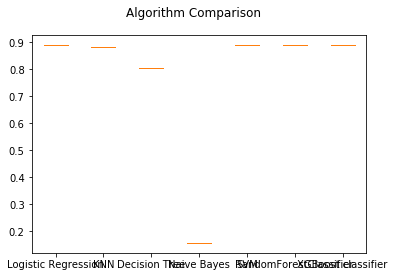

In [134]:
test_size=0.33

models = []
models.append(('Logistic Regression', LogisticRegression()))

models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RandomForestClassifier',RandomForestClassifier()))
models.append(('XGBoost classifier',XGBClassifier(n_estimators = 50, max_depth = 5, gamma = 100, random_state = 0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=2)
  cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  
  msg = "Accuracy :%s: %f " % (name, cv_results.mean())
  print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

**Selected Model**

XGBoost with 88.86% accuracy

In [135]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 50, max_depth = 5, gamma = 100, random_state = 0)
xgb.fit(X_train, y_train)
pred_train = xgb.predict(X_train)
print("Classification Report: XGBoost (training data)")
print(classification_report(y_train, pred_train))

Classification Report: XGBoost (training data)
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     63301
           1       0.00      0.00      0.00      7935

    accuracy                           0.89     71236
   macro avg       0.44      0.50      0.47     71236
weighted avg       0.79      0.89      0.84     71236



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sample tree visualization from the XGBoost model


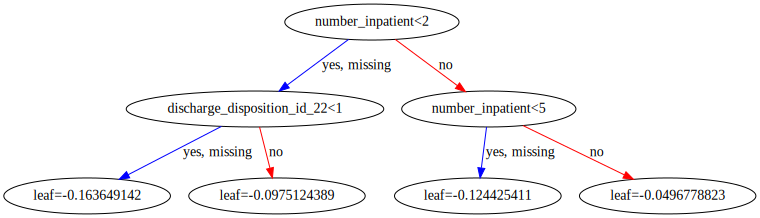

In [136]:
# Visualizing one tree in the XGBoost ensemble
print("Sample tree visualization from the XGBoost model")
to_graphviz(xgb, num_trees = 0)

Sample tree visualization from the XGBoost model


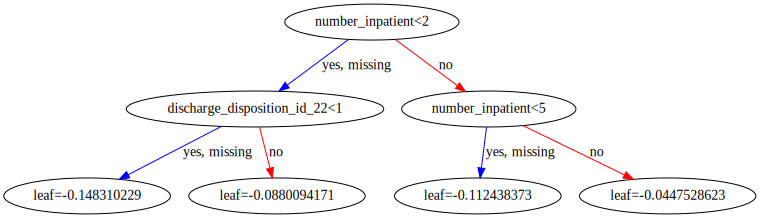

In [137]:
print("Sample tree visualization from the XGBoost model")
to_graphviz(xgb, num_trees = 1) 

**Patterns for predicting Readmission**

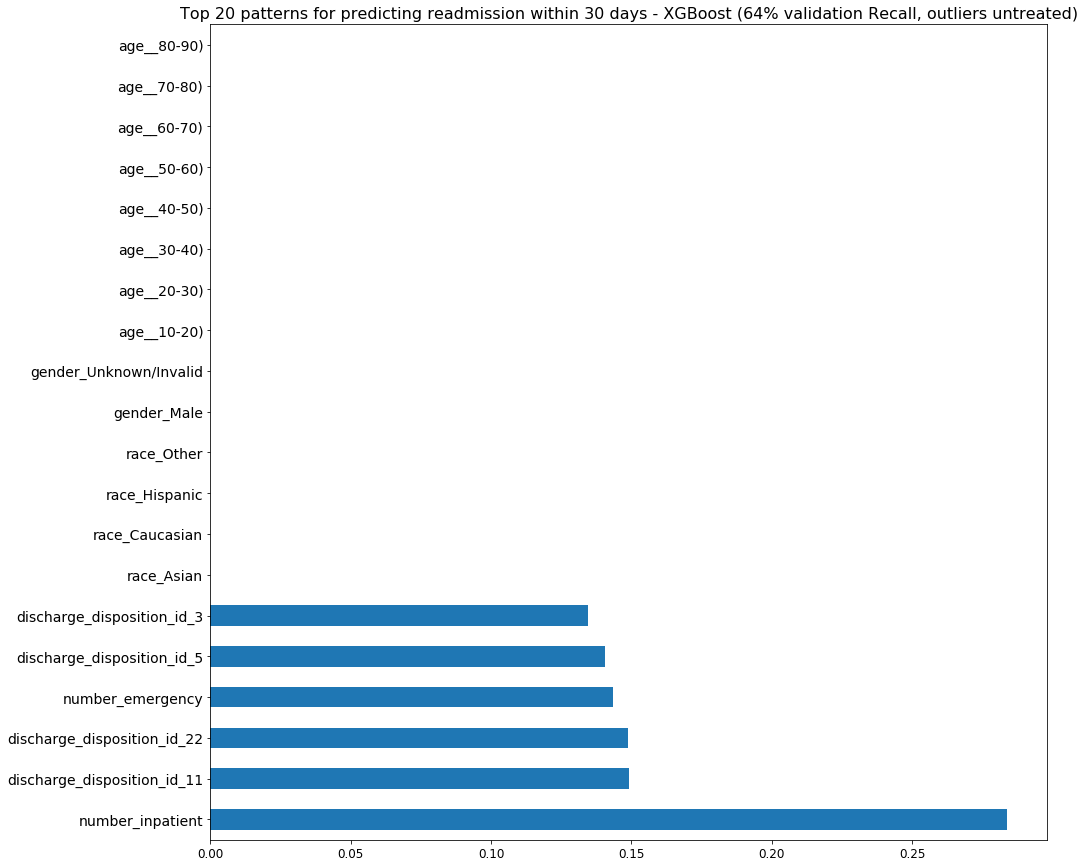

In [138]:

plt.figure(figsize = (15, 15))
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 patterns for predicting readmission within 30 days - XGBoost (64% validation Recall, outliers untreated)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.show()

The Key important fators:
*   number_emergency
*   discharge_position_id_3(Discharged/transferred to SNF)
*   discharge_position_id_5(Discharged/transferred to another type of inpatient care institution)
*   discharge_position_id_22(Discharged/transferred to another rehab fac including rehab )
*   discharge_position_id_11(Expired)
*  Causcasian
*   number_inpatient

